In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
def load_and_prepare_data(vector_path, labels_path):
    """Load feature vectors and labels."""
    # Load feature vectors
    X = pd.read_csv(vector_path)
    
    # Load original dataset with labels
    labels_df = pd.read_csv(labels_path)
    y = labels_df['label'].astype(int)  # Ensure labels are integers
    
    return X, y

In [4]:
def evaluate_model(model, X_test, y_test, model_name):
    """Evaluate model performance using multiple metrics."""
    # Get predictions
    if isinstance(model, Sequential):  # If it's a Neural Network
        y_pred_proba = model.predict(X_test)
        y_pred = np.argmax(y_pred_proba, axis=1)
    elif hasattr(model, 'predict_proba'):
        y_pred_proba = model.predict_proba(X_test)
        y_pred = np.argmax(y_pred_proba, axis=1)
    else:
        y_pred = model.predict(X_test)
        y_pred_proba = None
    
    # Convert y_test to numpy array if it's not already
    y_test = np.array(y_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Calculate ROC AUC for multi-class
    if y_pred_proba is not None:
        auc_scores = []
        for i in range(len(np.unique(y_test))):
            mask = y_test == i
            if np.any(mask):
                auc = roc_auc_score((y_test == i).astype(int), y_pred_proba[:, i])
                auc_scores.append(auc)
        mean_auc = np.mean(auc_scores)
    else:
        mean_auc = None
    
    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': mean_auc,
        'confusion_matrix': cm,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }

In [5]:
def plot_results(results, model_name, y_test):
    """Plot confusion matrix and ROC curve."""
    # Confusion Matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(results['confusion_matrix'], 
                annot=True, 
                fmt='d',
                cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # ROC Curve (if applicable)
    if results['y_pred_proba'] is not None:
        plt.figure(figsize=(10, 8))
        for i in range(len(np.unique(y_test))):
            fpr, tpr, _ = roc_curve((y_test == i).astype(int), 
                                  results['y_pred_proba'][:, i])
            plt.plot(fpr, tpr, label=f'Class {i}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {model_name}')
        plt.legend()
        plt.show()

In [6]:
def evaluate_all_models(X_train, X_test, y_train, y_test, models, input_dim, num_classes):
    """Evaluate all models and store results."""
    results = {}
    
    # Traditional ML models
    for name, model in models:
        print(f"\nTraining {name}...")
        model.fit(X_train, y_train)
        results[name] = evaluate_model(model, X_test, y_test, name)
        plot_results(results[name], name, y_test)
        
    # Neural Network
    print("\nTraining Neural Network...")
    model = Sequential([
        Dense(256, activation='relu', input_dim=input_dim),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
    
    early_stopping = EarlyStopping(monitor='val_loss', 
                                 patience=5, 
                                 restore_best_weights=True)
    
    history = model.fit(X_train, y_train,
                       validation_split=0.2,
                       epochs=50,
                       batch_size=32,
                       callbacks=[early_stopping],
                       verbose=1)
    
    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
    results['Neural Network'] = evaluate_model(model, X_test, y_test, 'Neural Network')
    plot_results(results['Neural Network'], 'Neural Network', y_test)
    
    return results

In [7]:
def generate_report(results):
    """Generate a detailed report of all model performances."""
    report = "Model Evaluation Report\n" + "="*50 + "\n\n"
    
    # Create comparison table
    comparison = []
    for model_name, metrics in results.items():
        comparison.append({
            'Model': model_name,
            'Accuracy': metrics['accuracy'],
            'Precision': metrics['precision'],
            'Recall': metrics['recall'],
            'F1-Score': metrics['f1'],
            'AUC': metrics['auc']
        })
    
    df_comparison = pd.DataFrame(comparison)
    report += "Model Comparison:\n"
    report += str(df_comparison.round(4)) + "\n\n"
    
    # Find best model for each metric
    metrics = ['Accuracy', 'Precision', 'Recall']
    for metric in metrics:
        best_model = df_comparison.loc[df_comparison[metric].idxmax()]
        report += f"Best {metric}: {best_model['Model']} ({best_model[metric]:.4f})\n"
    
    return report


Evaluating BOW representations...

Training Logistic Regression...


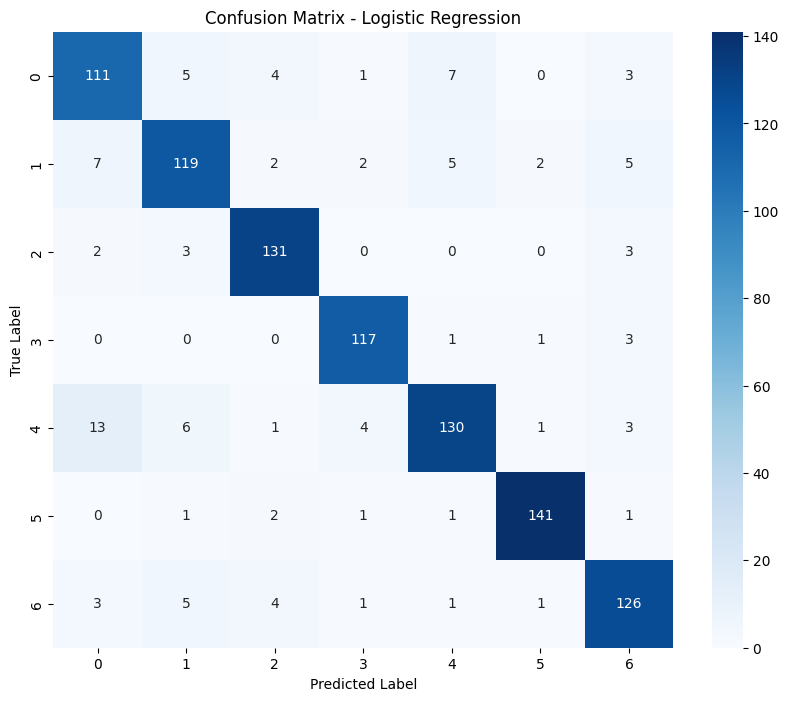

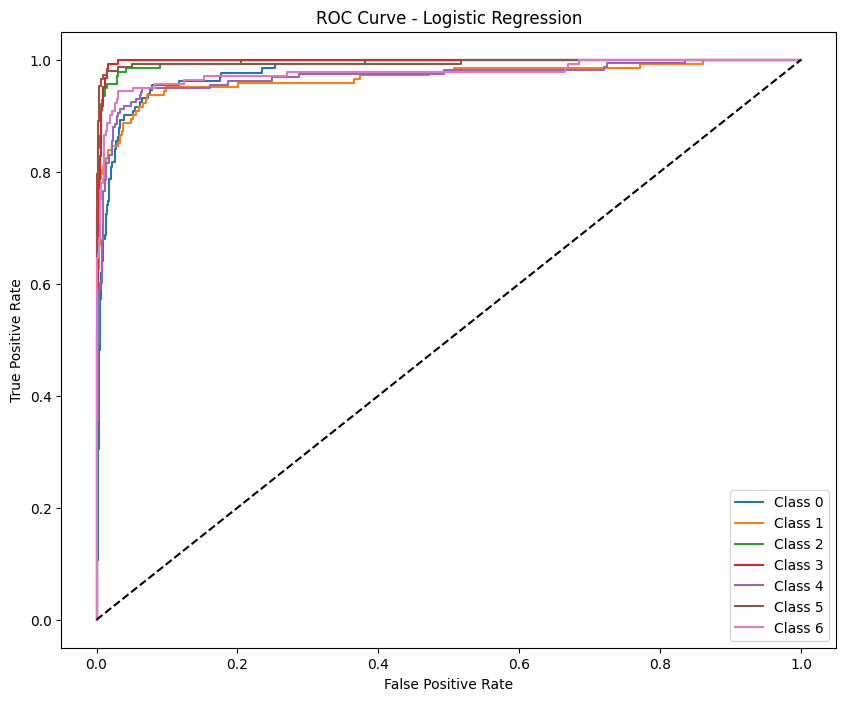


Training XGBoost...


c:\Users\MSI\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:07:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


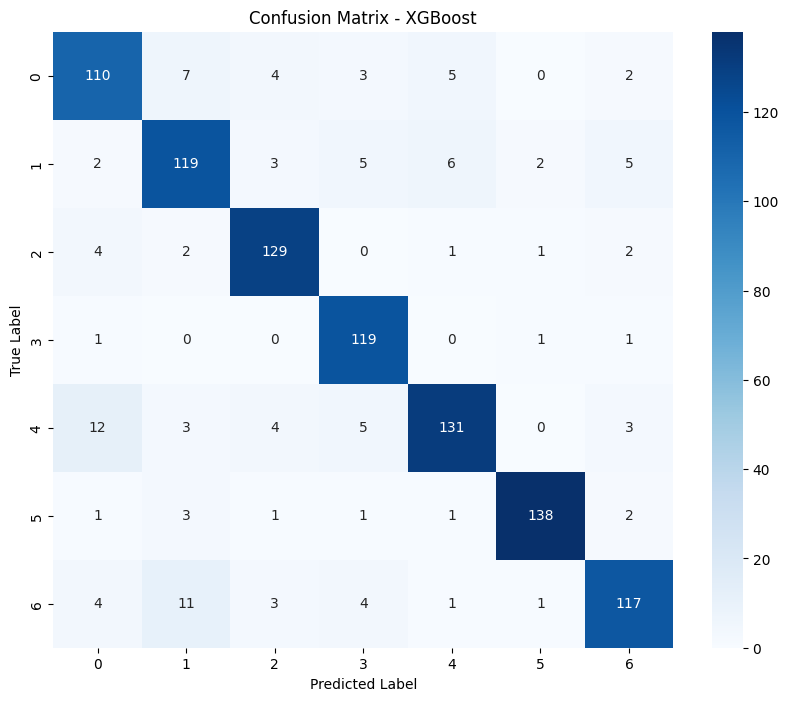

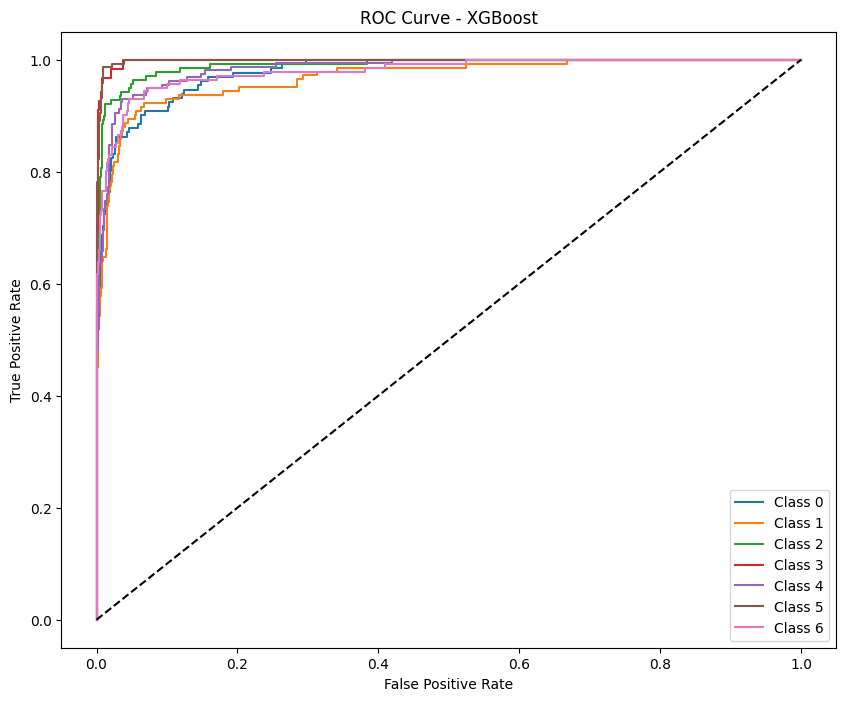


Training Decision Tree...


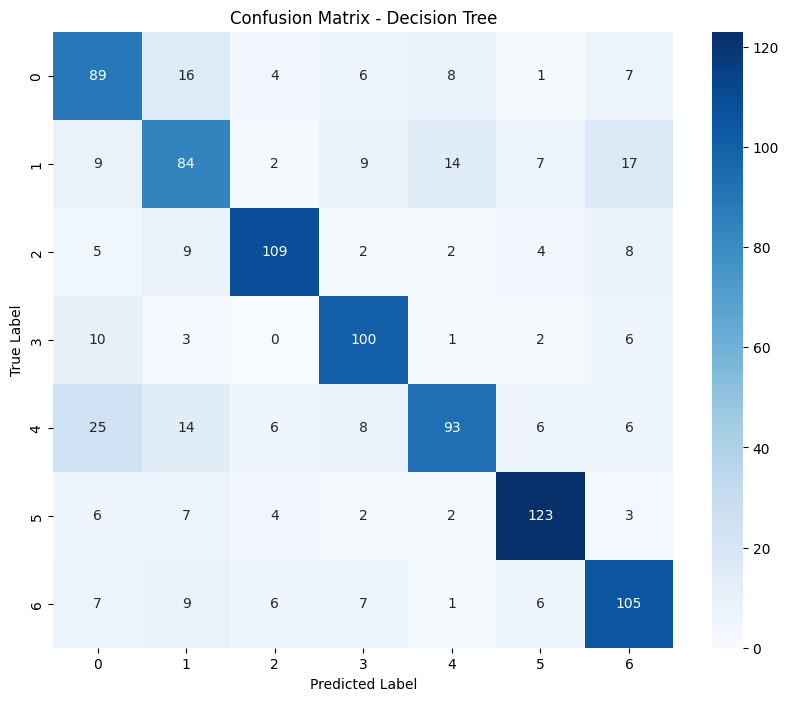

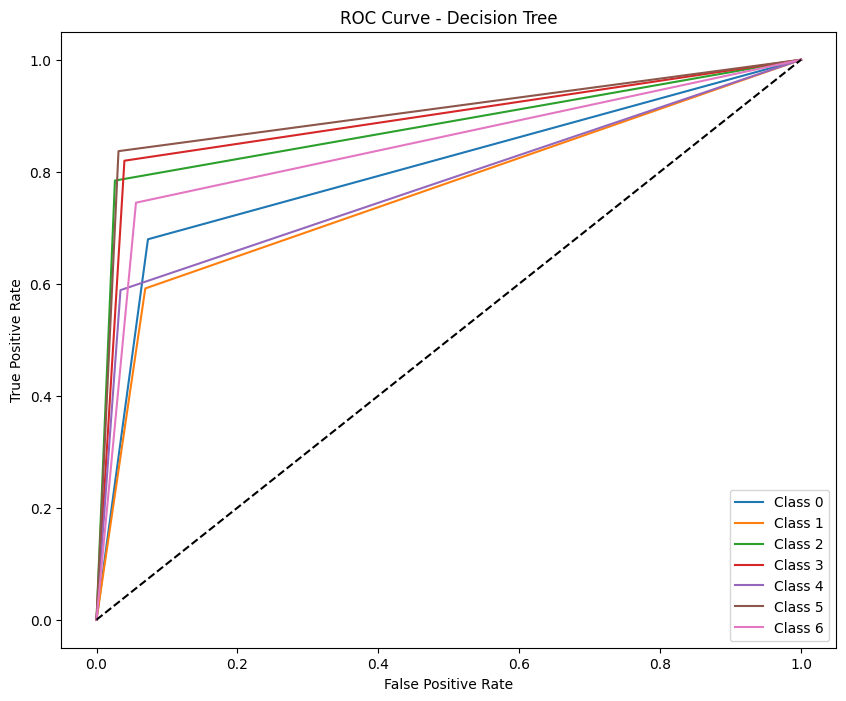


Training RandomForest...


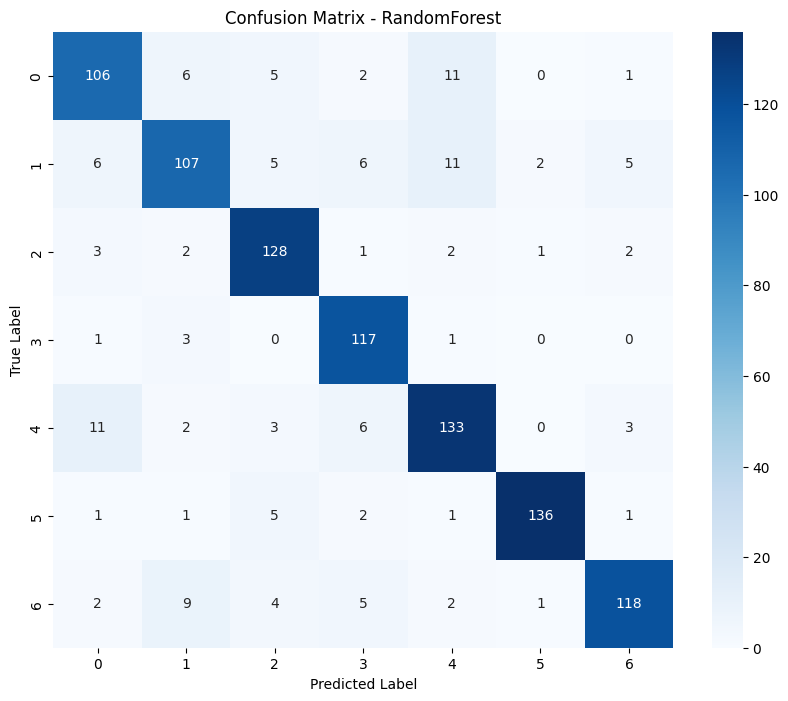

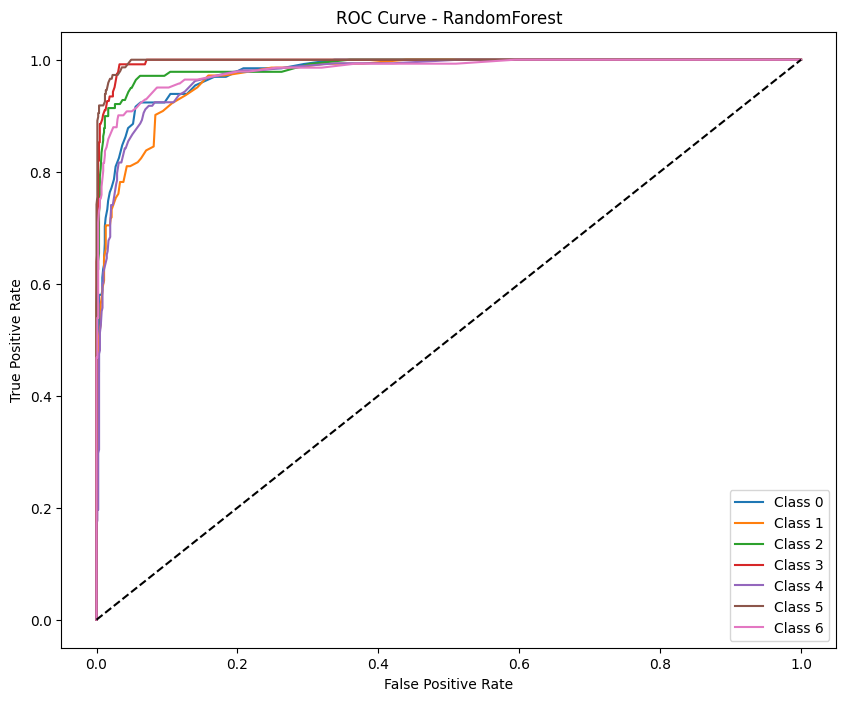


Training K-NN...


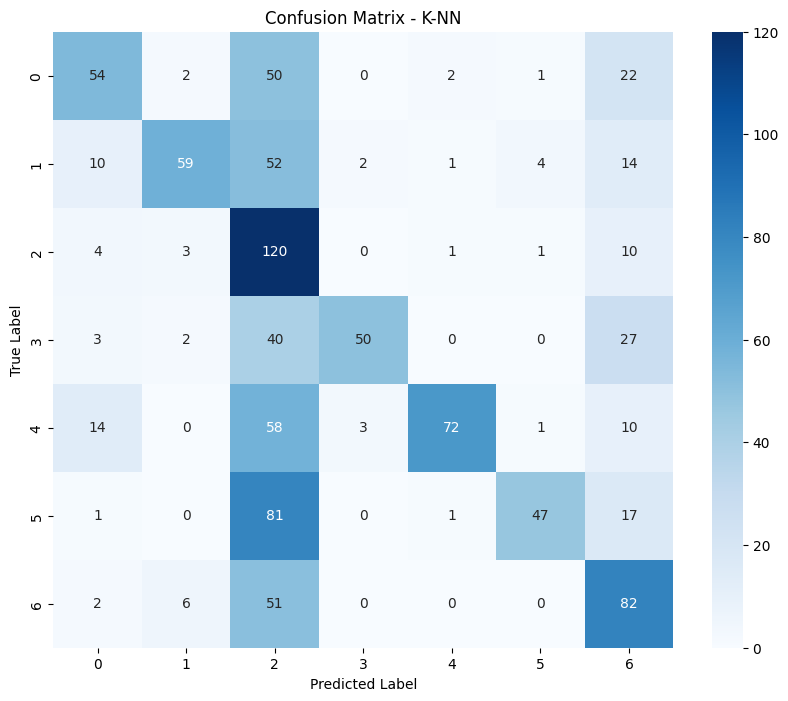

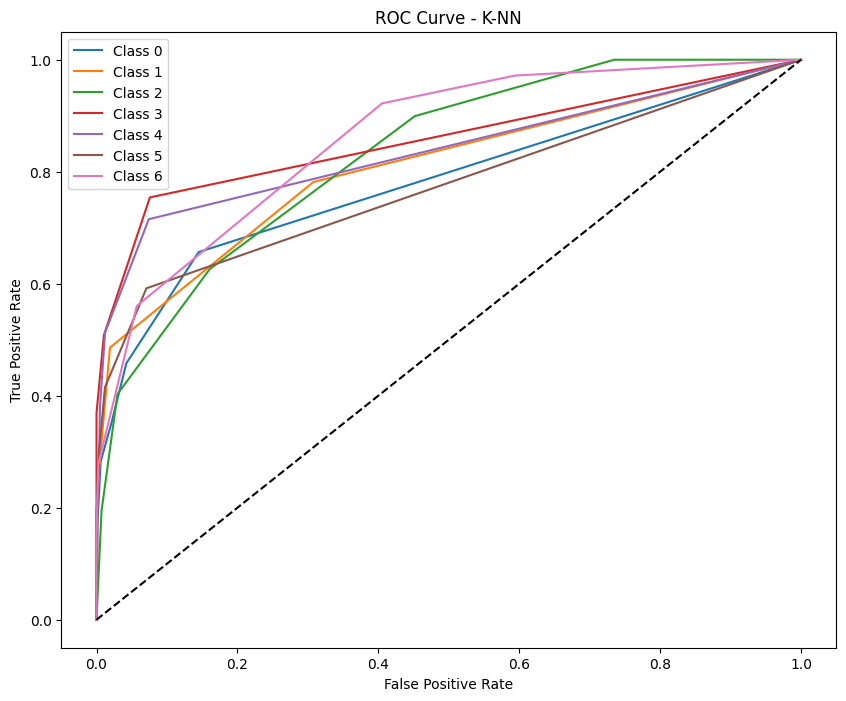


Training LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039088 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 20180
[LightGBM] [Info] Number of data points in the train set: 3920, number of used features: 4431
[LightGBM] [Info] Start training from score -1.929966
[LightGBM] [Info] Start training from score -1.949488
[LightGBM] [Info] Start training from score -1.944126
[LightGBM] [Info] Start training from score -1.914273
[LightGBM] [Info] Start training from score -1.978581
[LightGBM] [Info] Start training from score -1.958489
[LightGBM] [Info] Start training from score -1.947697


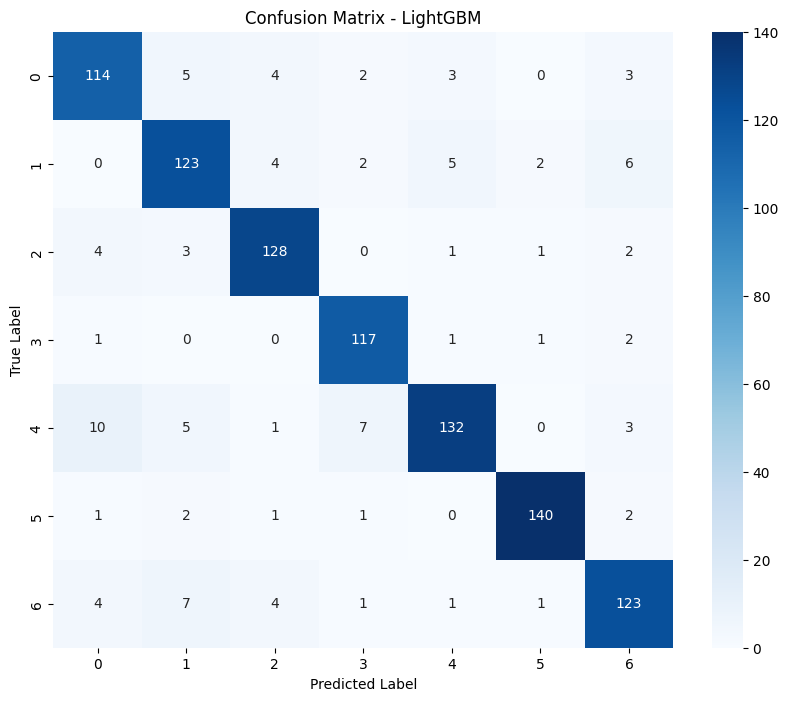

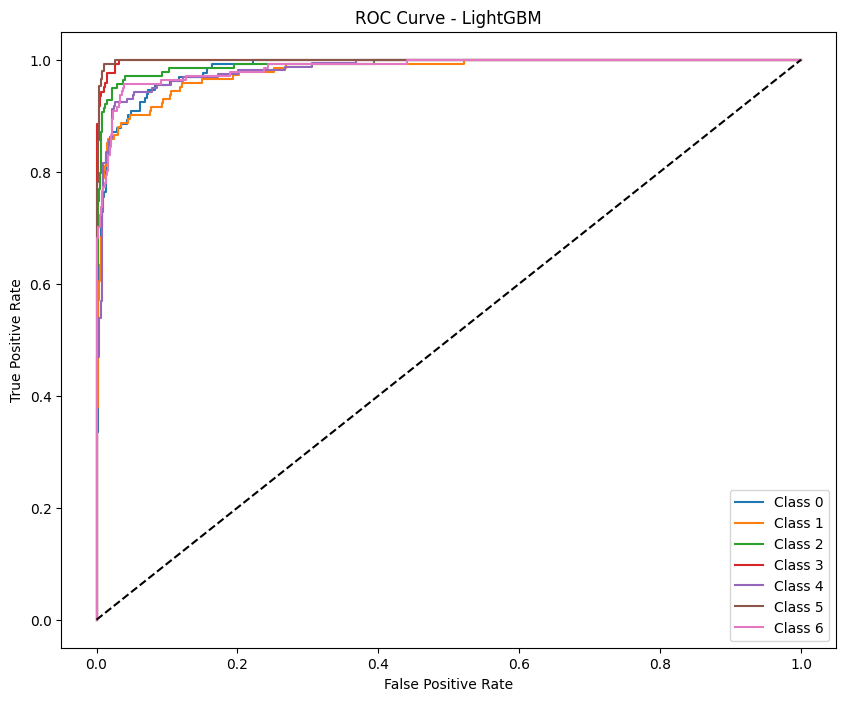


Training Neural Network...


c:\Users\MSI\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.2362 - loss: 2.6305 - val_accuracy: 0.7130 - val_loss: 1.3478
Epoch 2/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.4767 - loss: 1.4471 - val_accuracy: 0.8291 - val_loss: 0.8201
Epoch 3/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6665 - loss: 0.9399 - val_accuracy: 0.8699 - val_loss: 0.5605
Epoch 4/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8081 - loss: 0.5905 - val_accuracy: 0.8763 - val_loss: 0.4635
Epoch 5/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8666 - loss: 0.4304 - val_accuracy: 0.8814 - val_loss: 0.4441
Epoch 6/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8887 - loss: 0.3396 - val_accuracy: 0.8788 - val_loss: 0.4433
Epoch 7/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9095 - loss: 0.2781 - val_accuracy: 0.8712 - val_loss: 0.4827
Epoch 8/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9424 - loss: 0.2016 - val_accuracy: 0.8699 - v

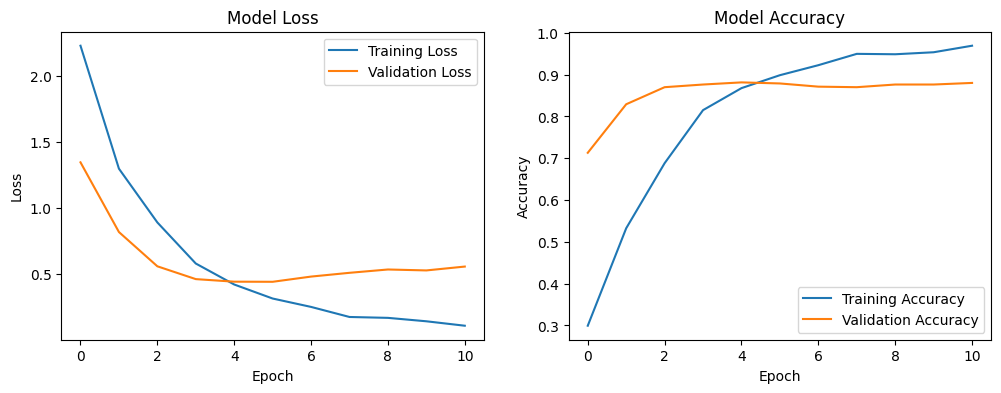

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


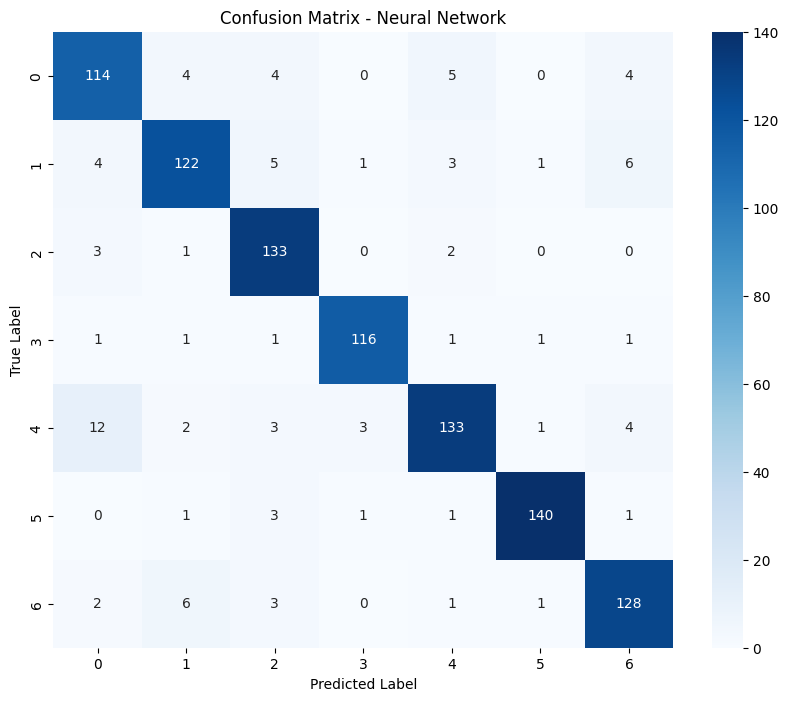

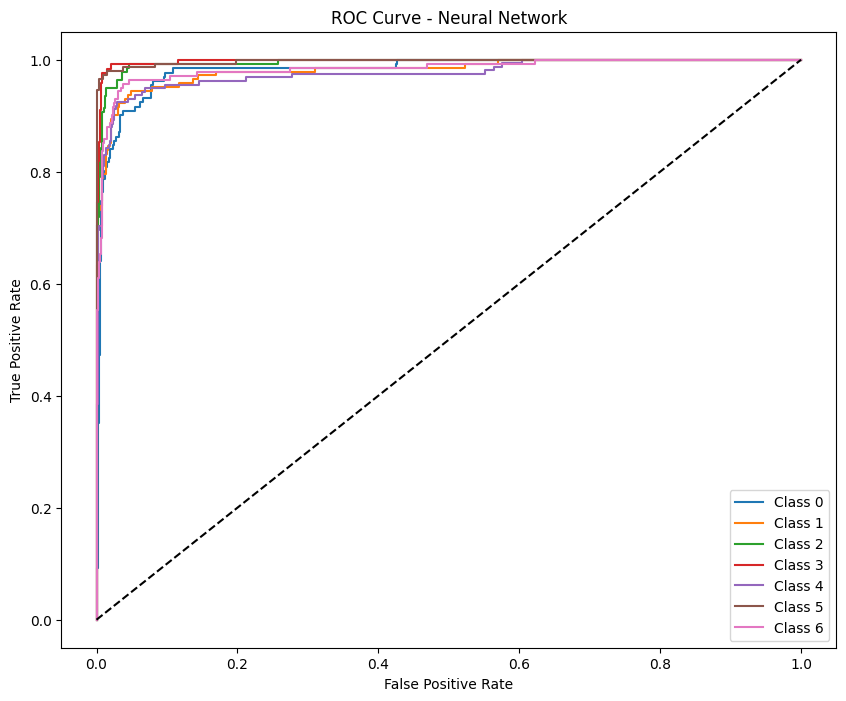


Results for BOW:
Model Evaluation Report

Model Comparison:
                 Model  Accuracy  Precision  Recall  F1-Score     AUC
0  Logistic Regression    0.8929     0.8931  0.8929    0.8926  0.9828
1              XGBoost    0.8806     0.8818  0.8806    0.8803  0.9851
2        Decision Tree    0.7173     0.7226  0.7173    0.7171  0.8368
3         RandomForest    0.8622     0.8636  0.8622    0.8617  0.9838
4                 K-NN    0.4939     0.6977  0.4939    0.5157  0.8205
5             LightGBM    0.8949     0.8957  0.8949    0.8948  0.9888
6       Neural Network    0.9041     0.9051  0.9041    0.9040  0.9873

Best Accuracy: Neural Network (0.9041)
Best Precision: Neural Network (0.9051)
Best Recall: Neural Network (0.9041)


Evaluating TF-IDF representations...

Training Logistic Regression...


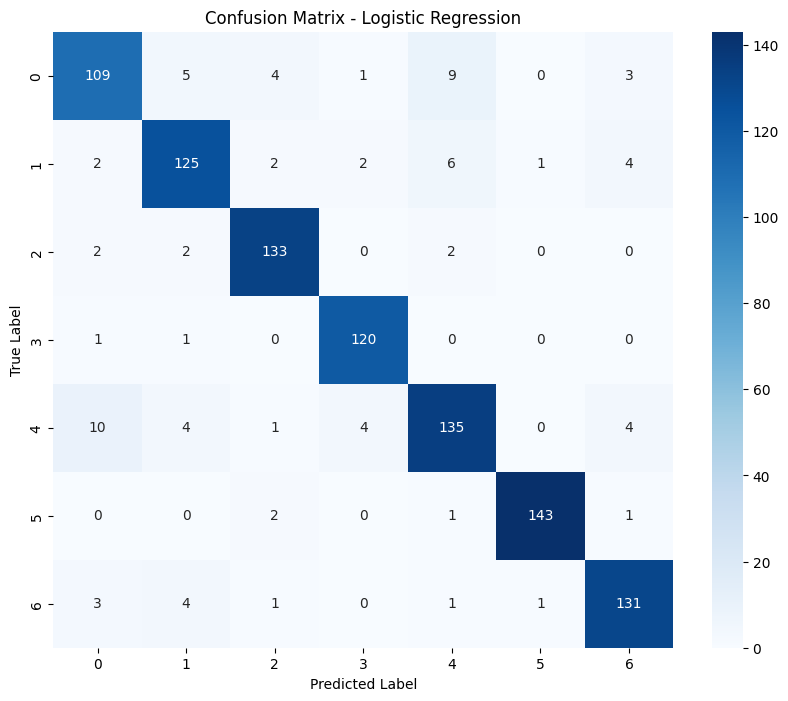

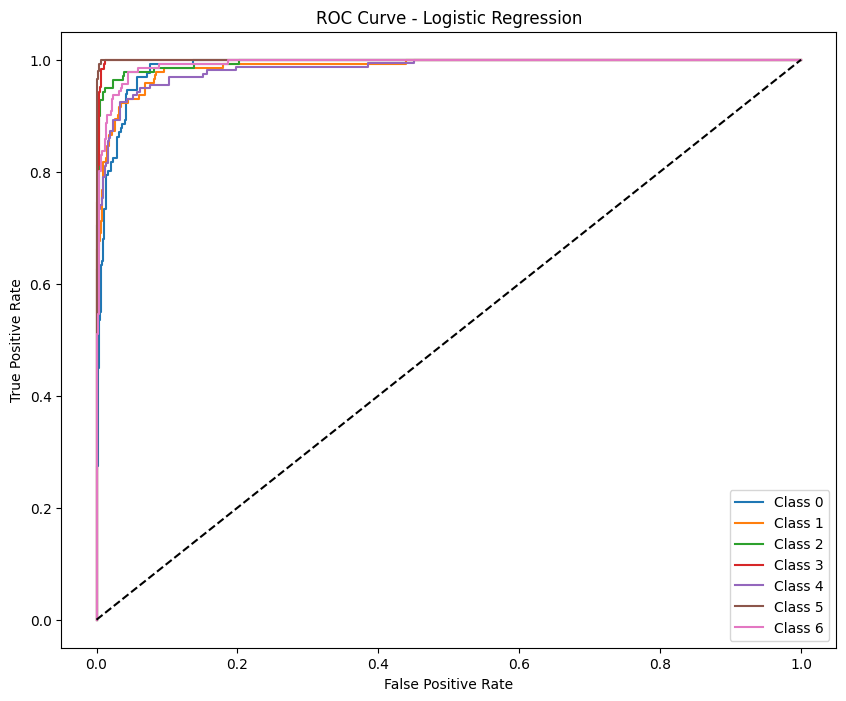


Training XGBoost...


c:\Users\MSI\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:08:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


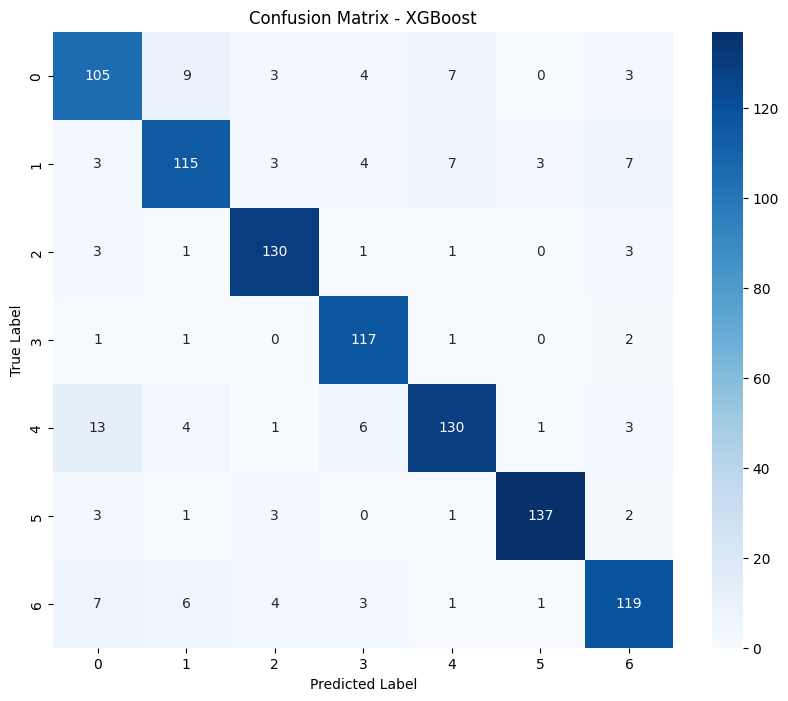

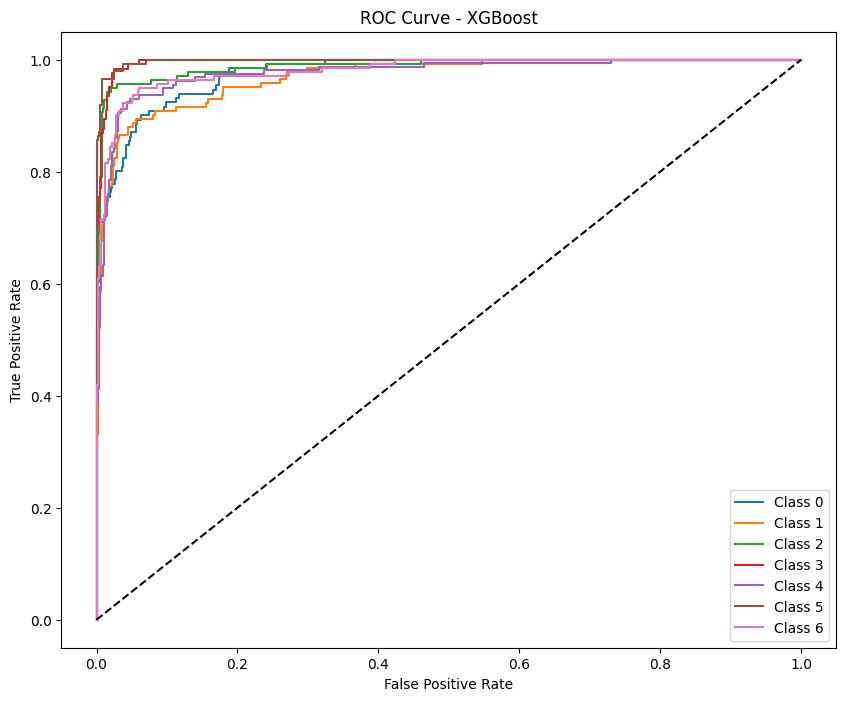


Training Decision Tree...


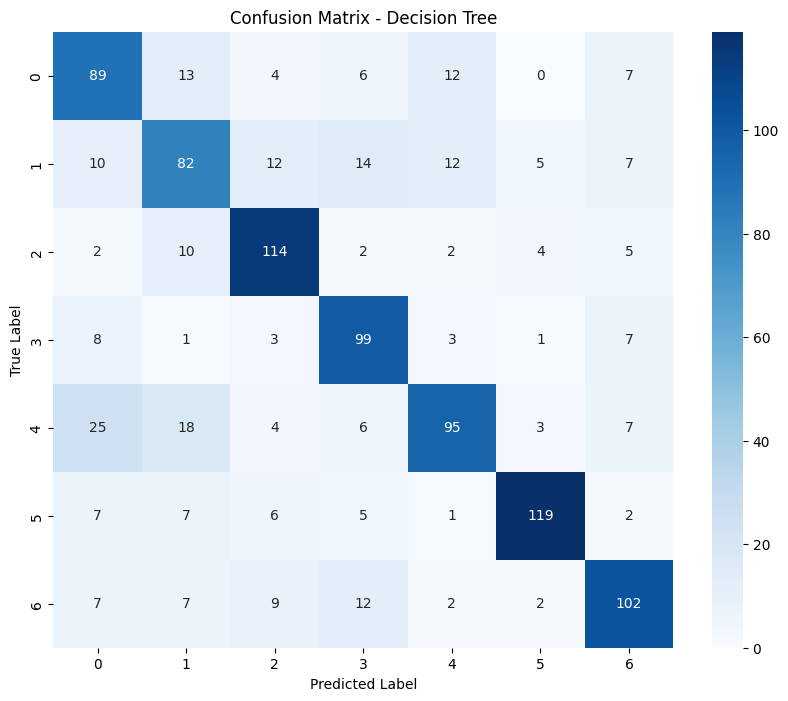

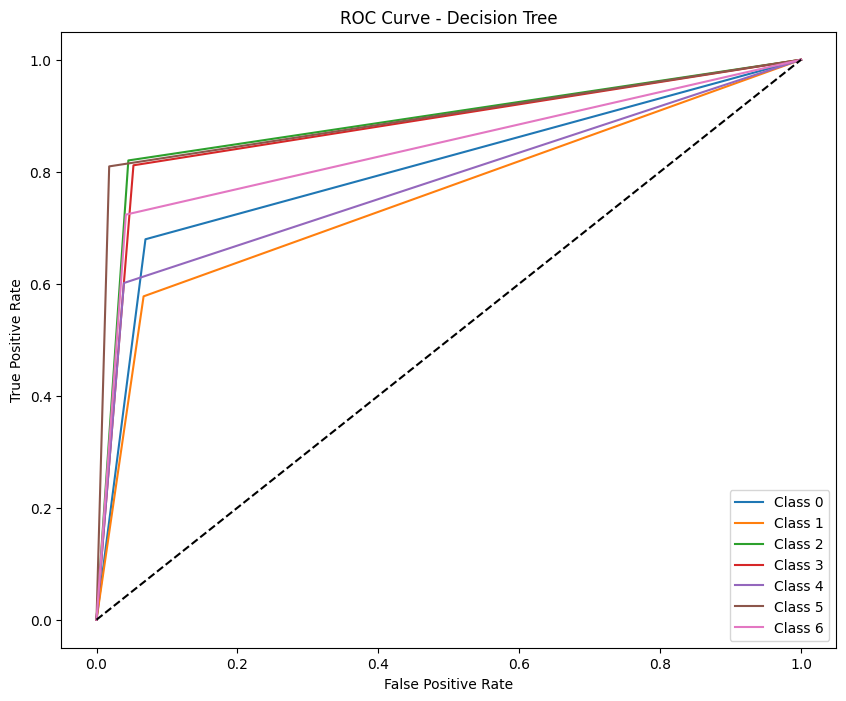


Training RandomForest...


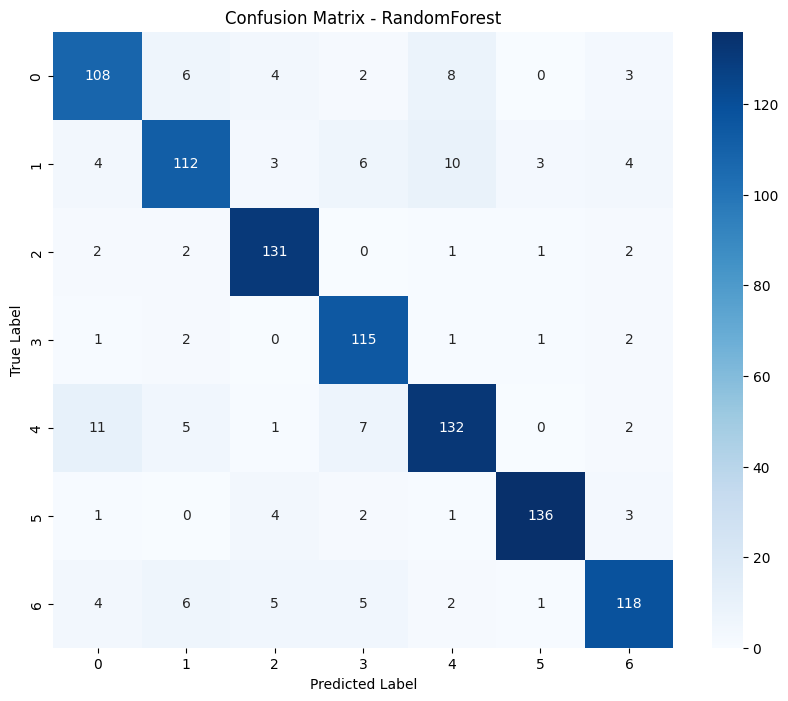

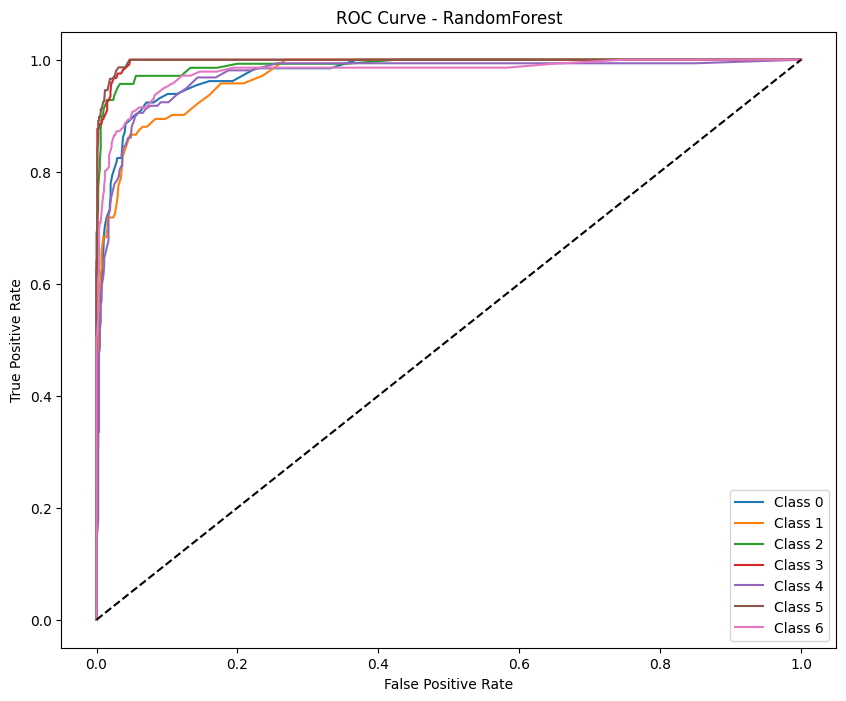


Training K-NN...


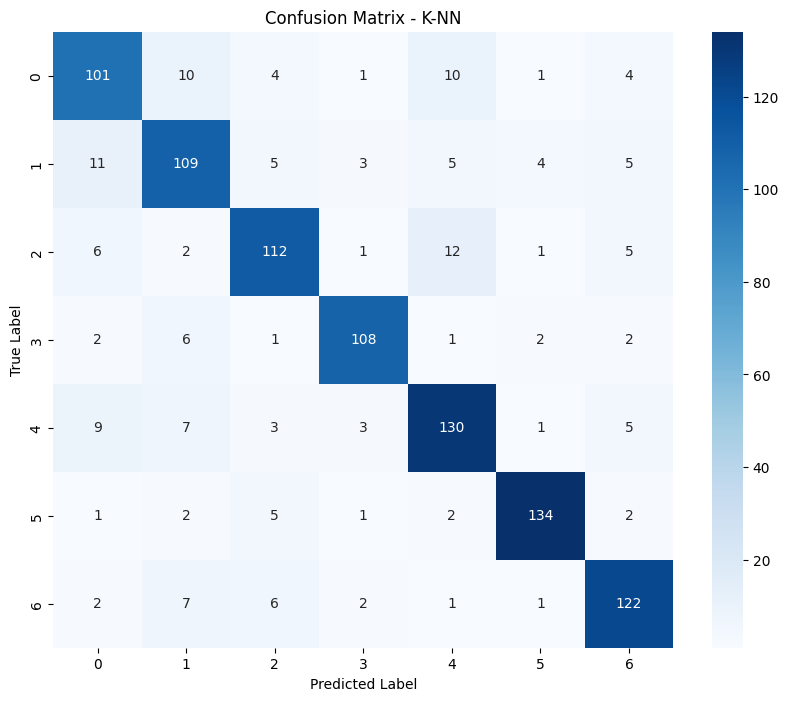

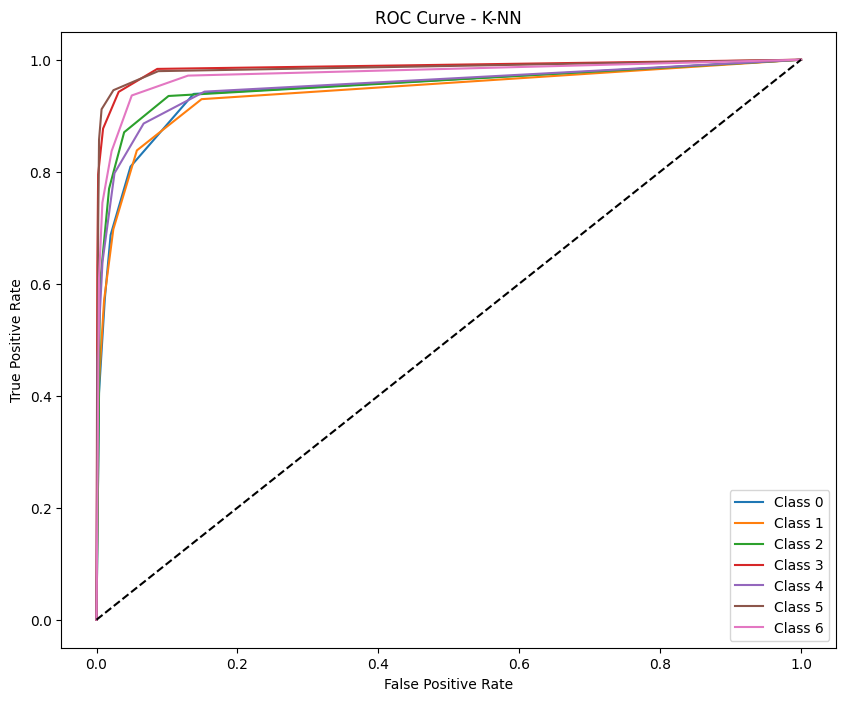


Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054521 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 124595
[LightGBM] [Info] Number of data points in the train set: 3920, number of used features: 4431
[LightGBM] [Info] Start training from score -1.929966
[LightGBM] [Info] Start training from score -1.949488
[LightGBM] [Info] Start training from score -1.944126
[LightGBM] [Info] Start training from score -1.914273
[LightGBM] [Info] Start training from score -1.978581
[LightGBM] [Info] Start training from score -1.958489
[LightGBM] [Info] Start training from score -1.947697


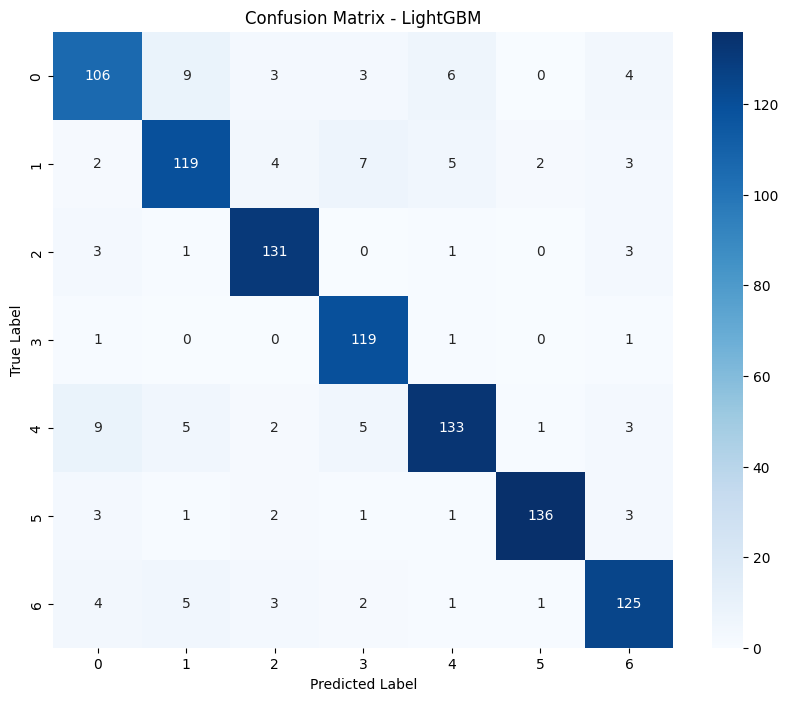

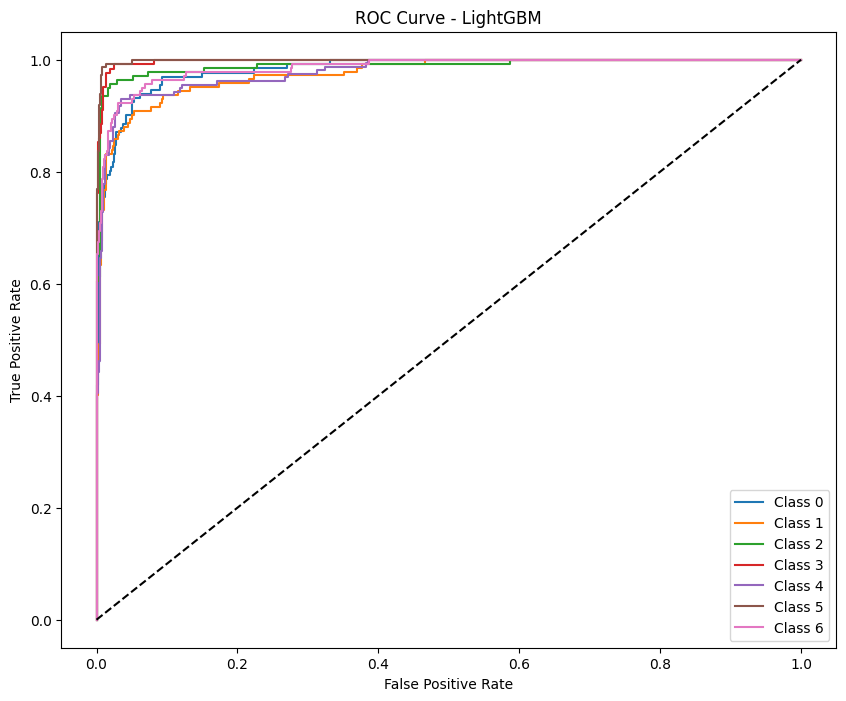


Training Neural Network...


c:\Users\MSI\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.2377 - loss: 2.6897 - val_accuracy: 0.3355 - val_loss: 1.8518
Epoch 2/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5979 - loss: 1.1431 - val_accuracy: 0.6224 - val_loss: 1.5460
Epoch 3/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7903 - loss: 0.6533 - val_accuracy: 0.7730 - val_loss: 1.1002
Epoch 4/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8806 - loss: 0.3766 - val_accuracy: 0.8457 - val_loss: 0.6881
Epoch 5/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9185 - loss: 0.2843 - val_accuracy: 0.8673 - val_loss: 0.4549
Epoch 6/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9416 - loss: 0.1980 - val_accuracy: 0.8776 - val_loss: 0.3932
Epoch 7/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9535 - loss: 0.1458 - val_accuracy: 0.8814 - val_loss: 0.4337
Epoch 8/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9607 - loss: 0.1349 - val_accuracy: 0.8776 - v

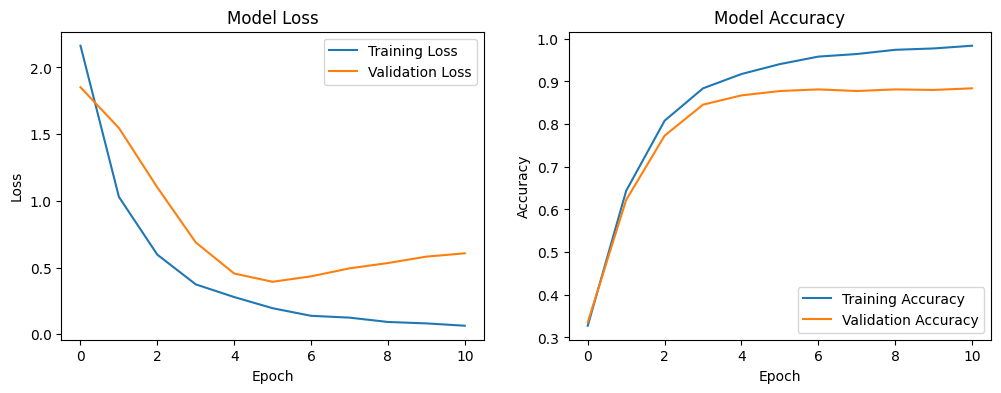

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


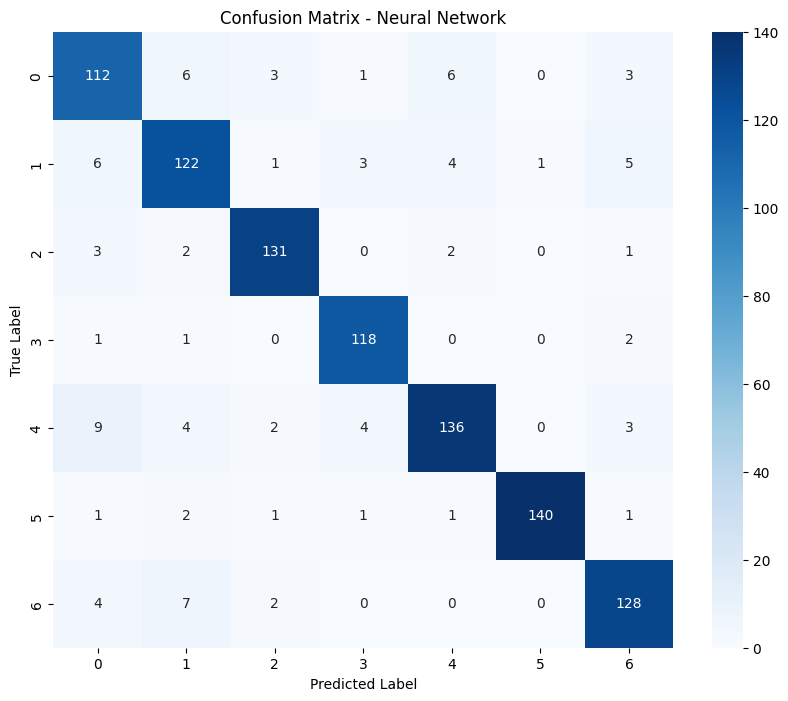

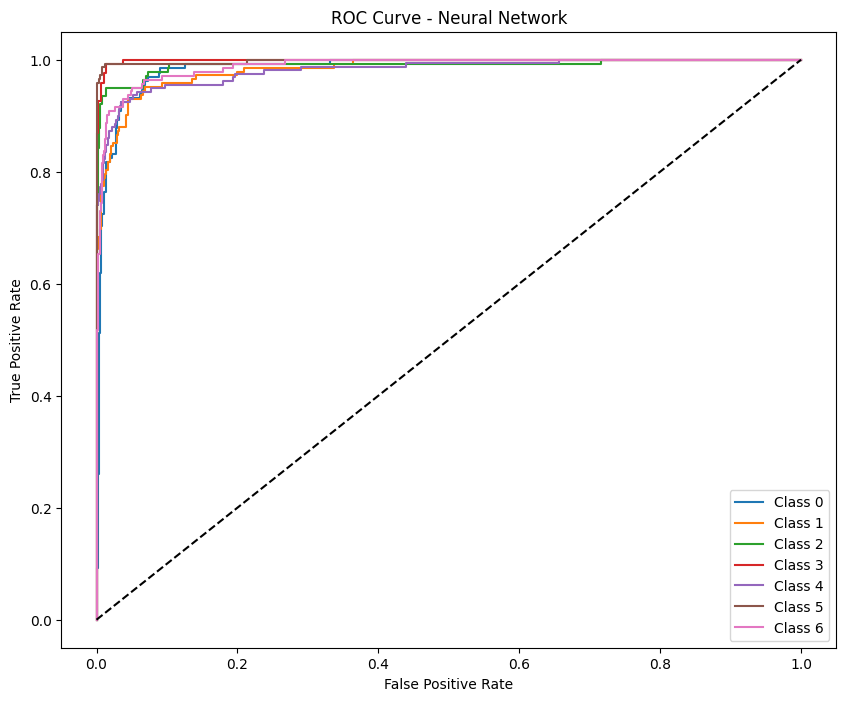


Results for TF-IDF:
Model Evaluation Report

Model Comparison:
                 Model  Accuracy  Precision  Recall  F1-Score     AUC
0  Logistic Regression    0.9143     0.9138  0.9143    0.9139  0.9922
1              XGBoost    0.8704     0.8710  0.8704    0.8701  0.9838
2        Decision Tree    0.7143     0.7194  0.7143    0.7141  0.8350
3         RandomForest    0.8694     0.8699  0.8694    0.8689  0.9835
4                 K-NN    0.8327     0.8333  0.8327    0.8329  0.9625
5             LightGBM    0.8867     0.8874  0.8867    0.8864  0.9868
6       Neural Network    0.9051     0.9061  0.9051    0.9053  0.9894

Best Accuracy: Logistic Regression (0.9143)
Best Precision: Logistic Regression (0.9138)
Best Recall: Logistic Regression (0.9143)


Evaluating Word2Vec representations...

Training Logistic Regression...


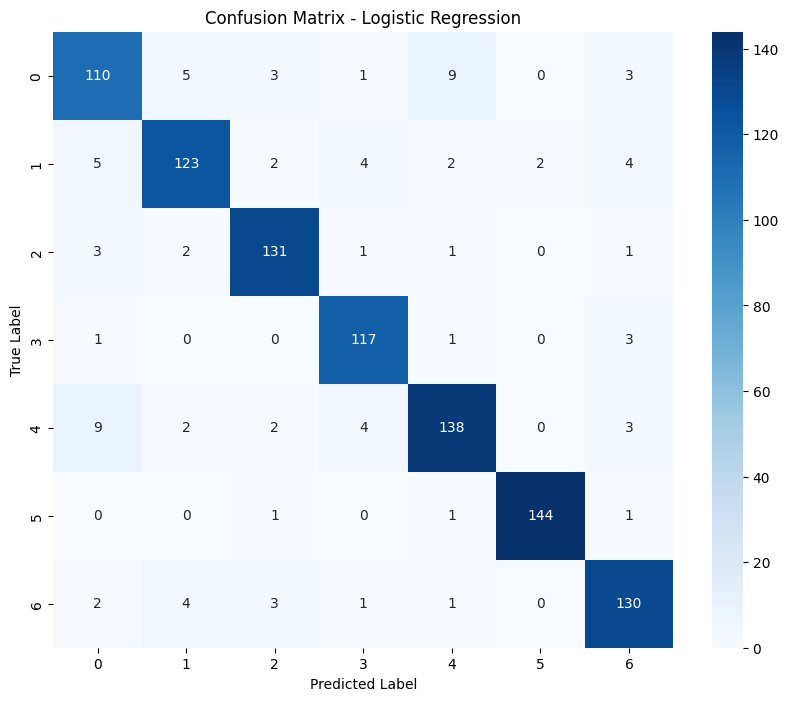

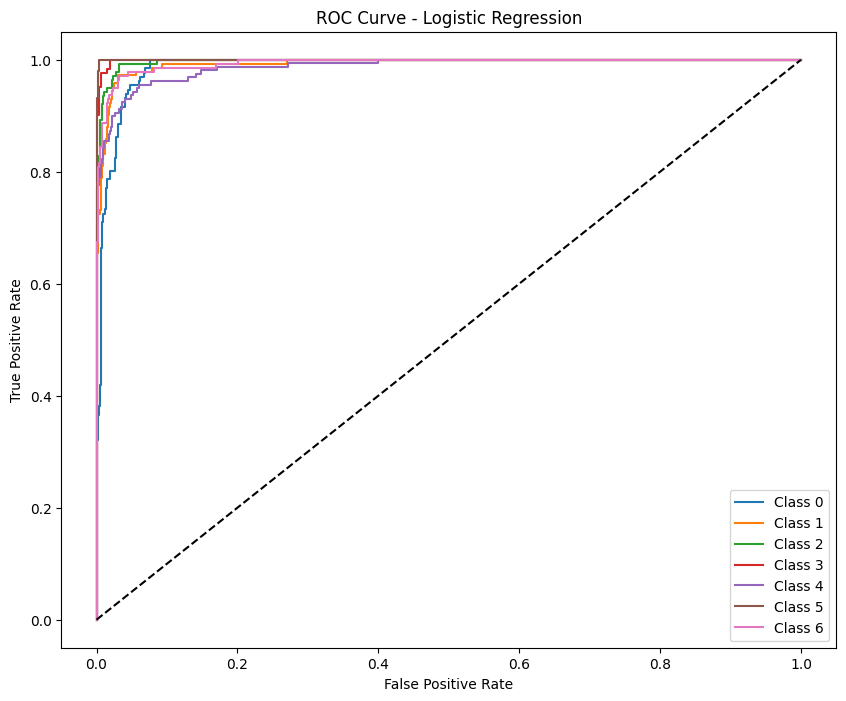


Training XGBoost...


c:\Users\MSI\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:10:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


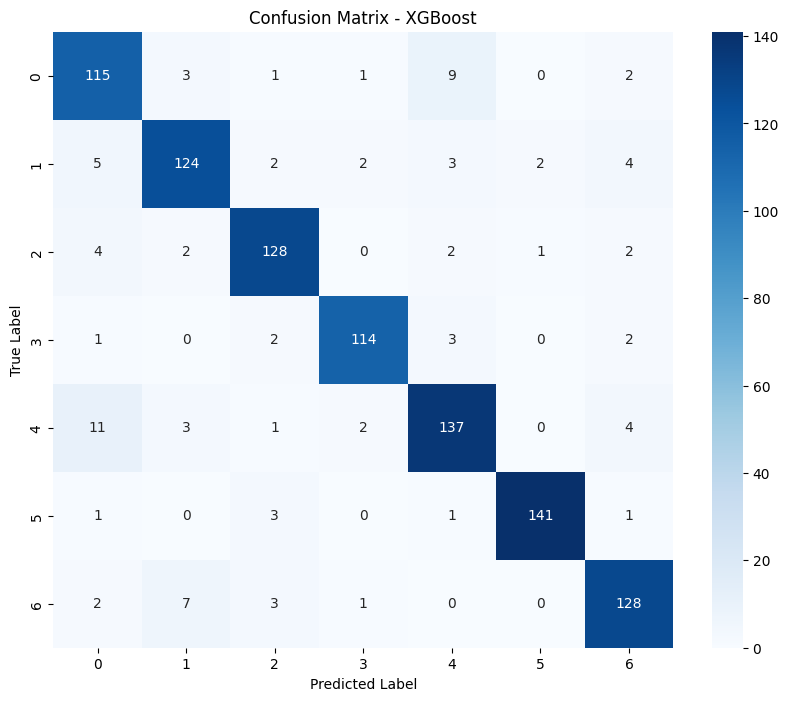

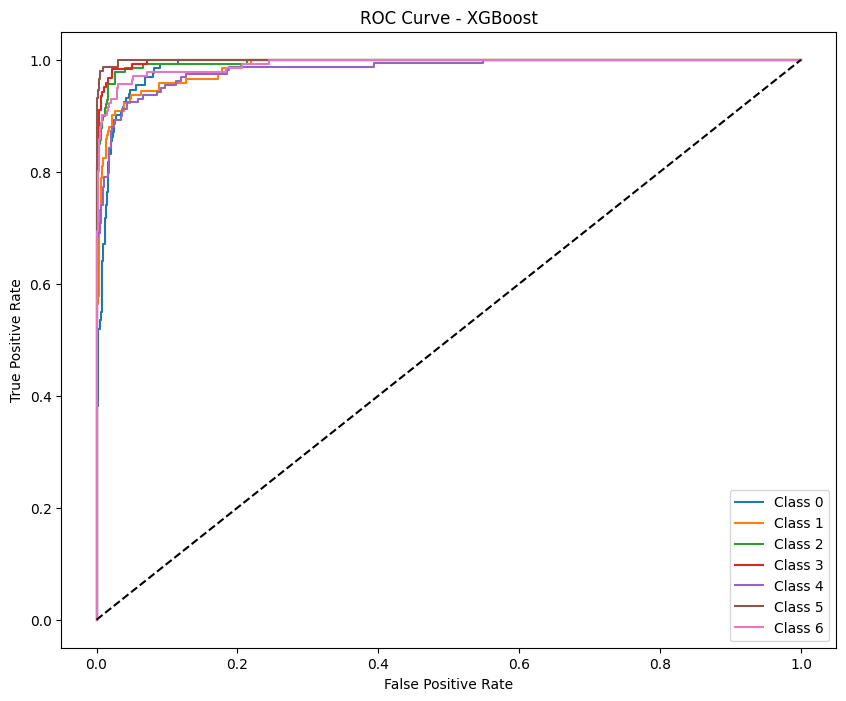


Training Decision Tree...


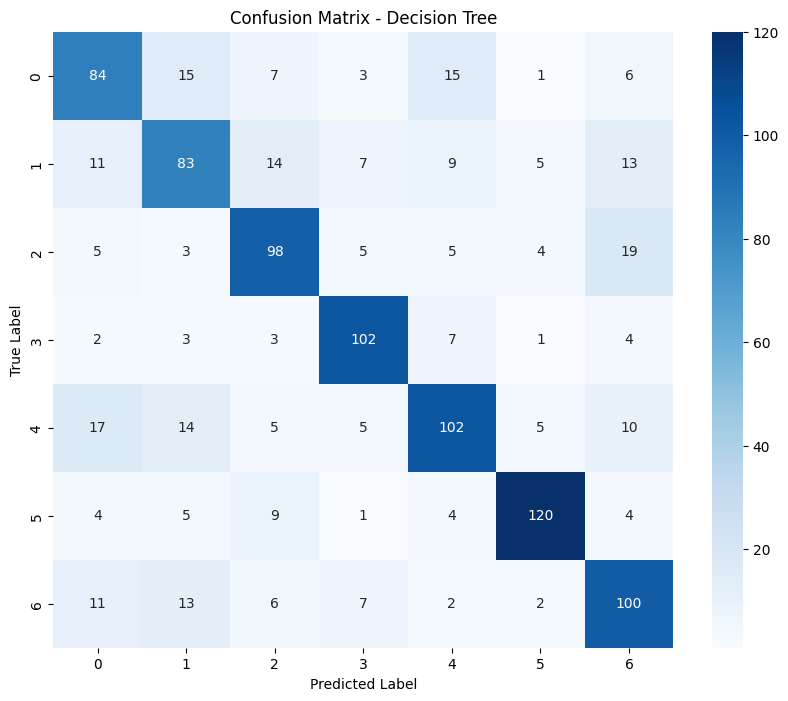

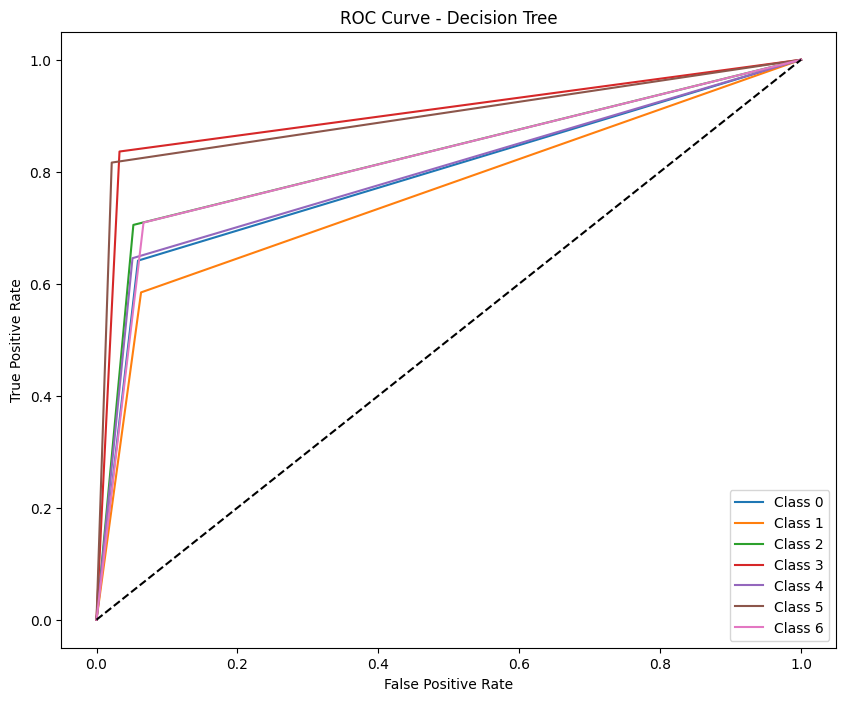


Training RandomForest...


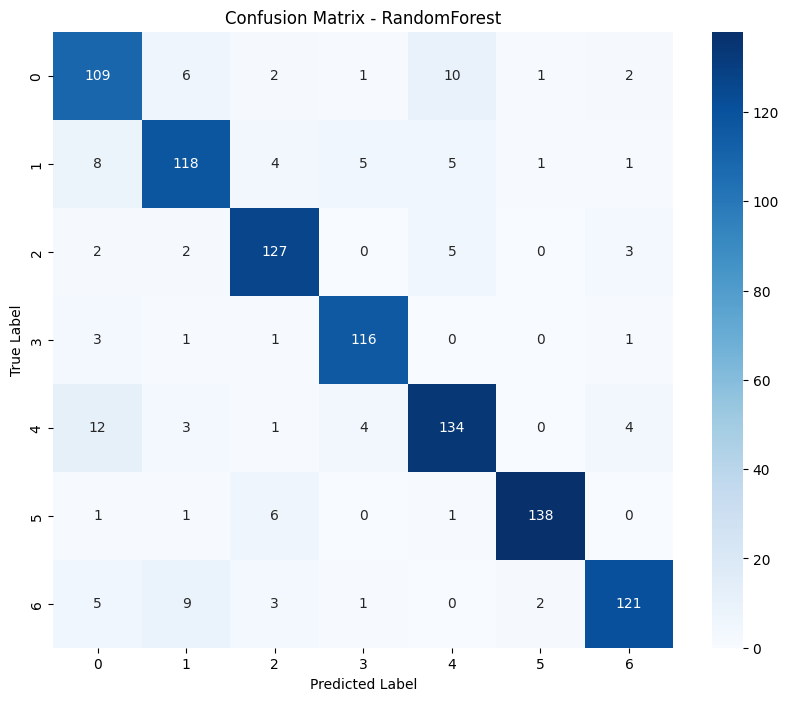

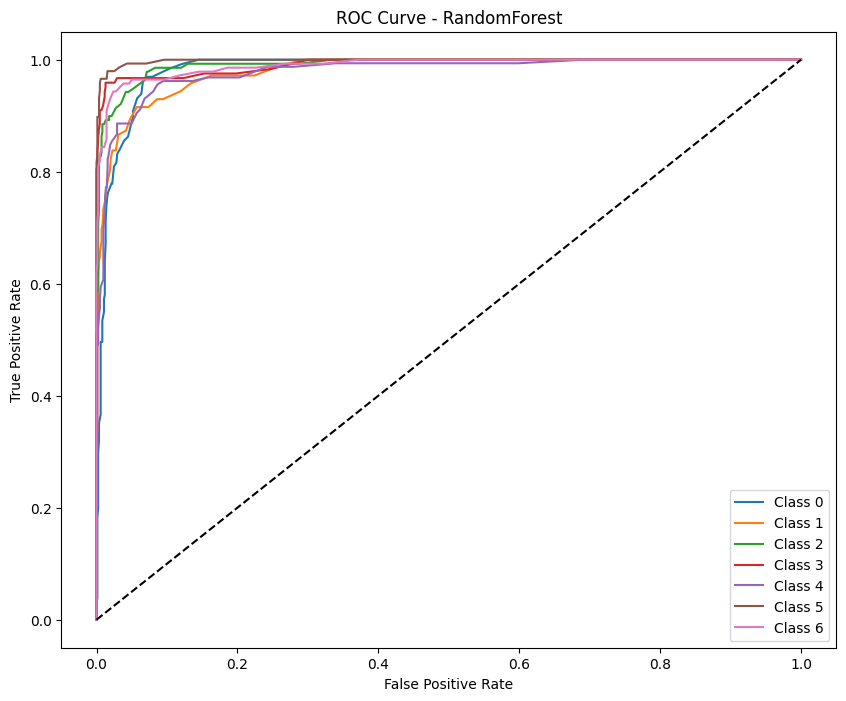


Training K-NN...


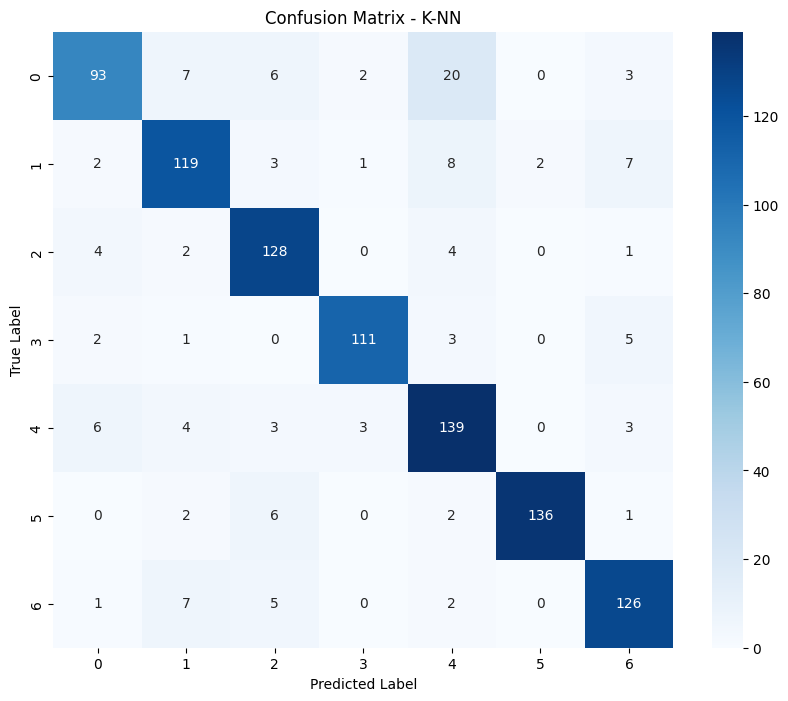

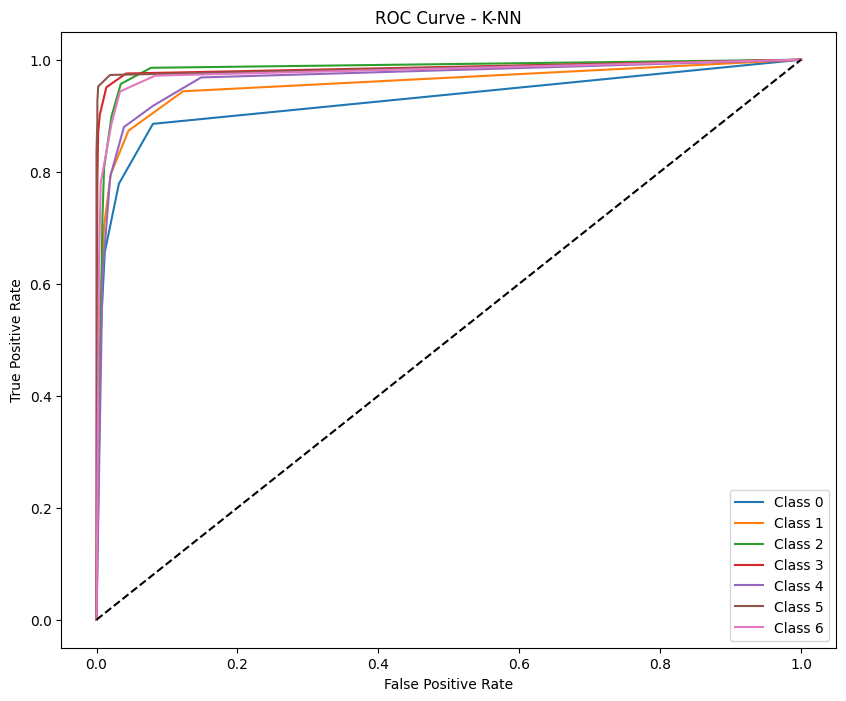


Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 127500
[LightGBM] [Info] Number of data points in the train set: 3920, number of used features: 500
[LightGBM] [Info] Start training from score -1.929966
[LightGBM] [Info] Start training from score -1.949488
[LightGBM] [Info] Start training from score -1.944126
[LightGBM] [Info] Start training from score -1.914273
[LightGBM] [Info] Start training from score -1.978581
[LightGBM] [Info] Start training from score -1.958489
[LightGBM] [Info] Start training from score -1.947697
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

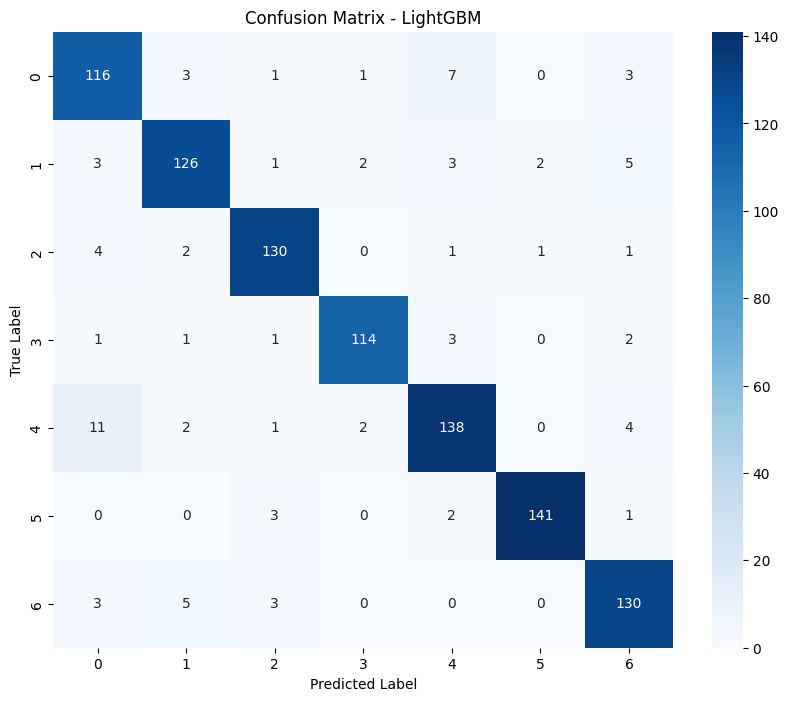

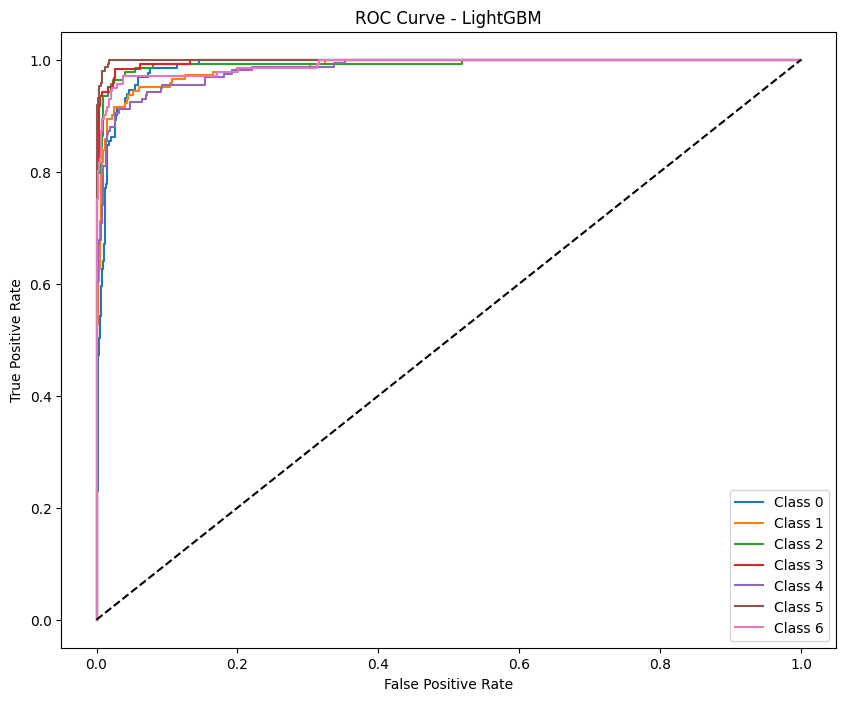


Training Neural Network...
Epoch 1/50


c:\Users\MSI\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.2846 - loss: 2.3344 - val_accuracy: 0.5357 - val_loss: 1.6077
Epoch 2/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6626 - loss: 1.0154 - val_accuracy: 0.7640 - val_loss: 1.0830
Epoch 3/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7568 - loss: 0.7497 - val_accuracy: 0.8291 - val_loss: 0.7090
Epoch 4/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7827 - loss: 0.6789 - val_accuracy: 0.8686 - val_loss: 0.4733
Epoch 5/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8218 - loss: 0.5446 - val_accuracy: 0.8622 - val_loss: 0.4188
Epoch 6/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8426 - loss: 0.4974 - val_accuracy: 0.8852 - val_loss: 0.3756
Epoch 7/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8583 - loss: 0.4606 - val_accuracy: 0.8890 - val_loss: 0.3641
Epoch 8/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8658 - loss: 0.4463 - val_accuracy: 0.8878 - val_loss: 0.3424
Epo

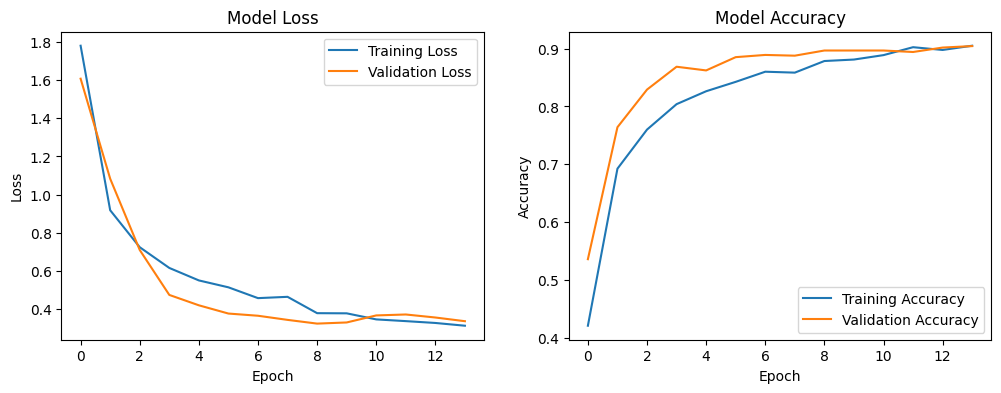

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


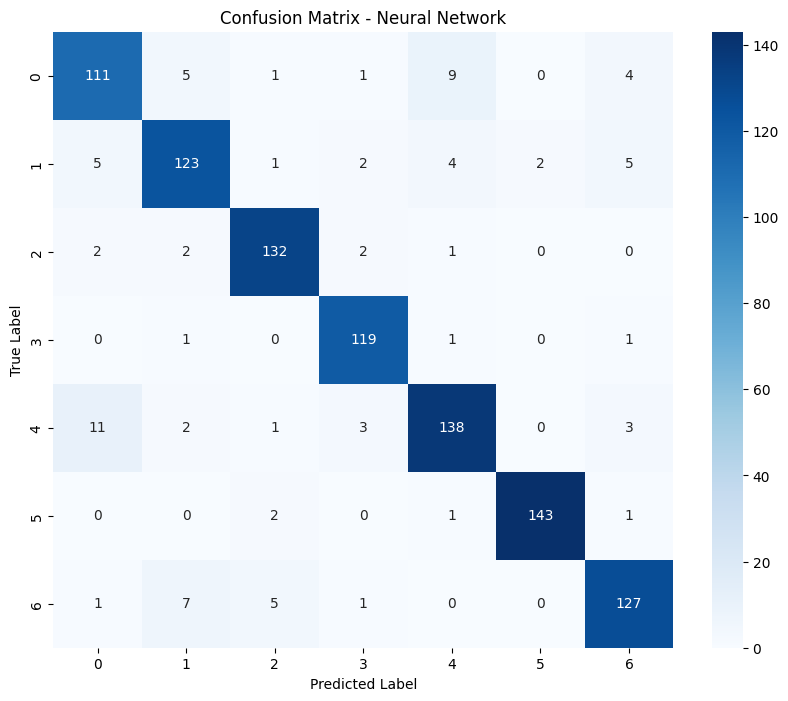

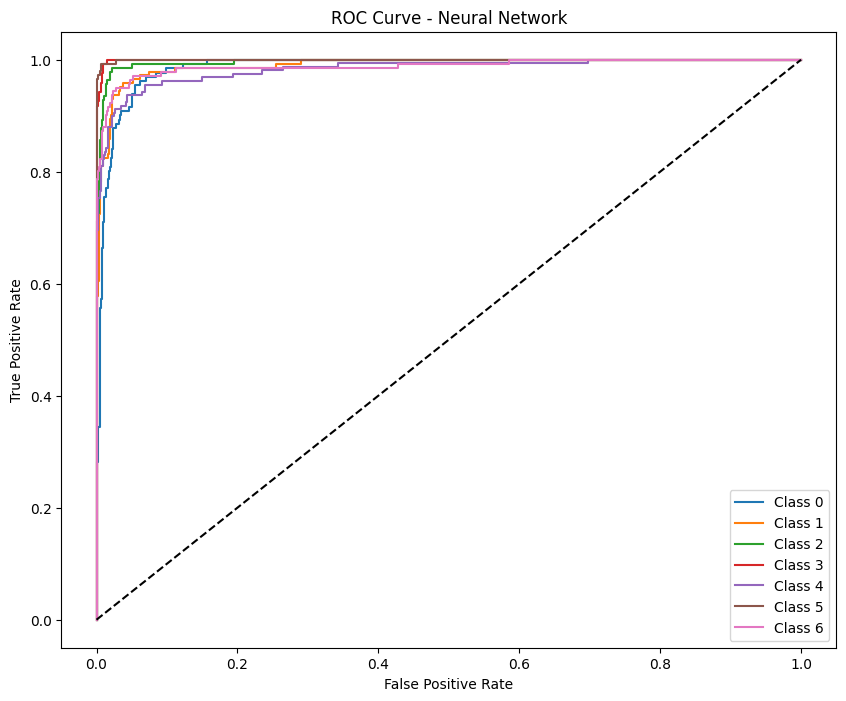


Results for Word2Vec:
Model Evaluation Report

Model Comparison:
                 Model  Accuracy  Precision  Recall  F1-Score     AUC
0  Logistic Regression    0.9112     0.9112  0.9112    0.9110  0.9940
1              XGBoost    0.9051     0.9060  0.9051    0.9054  0.9918
2        Decision Tree    0.7031     0.7047  0.7031    0.7031  0.8280
3         RandomForest    0.8806     0.8820  0.8806    0.8809  0.9877
4                 K-NN    0.8694     0.8728  0.8694    0.8692  0.9690
5             LightGBM    0.9133     0.9141  0.9133    0.9135  0.9911
6       Neural Network    0.9112     0.9110  0.9112    0.9110  0.9918

Best Accuracy: LightGBM (0.9133)
Best Precision: LightGBM (0.9141)
Best Recall: LightGBM (0.9133)



In [8]:
# Define vector types and their corresponding file names
vector_files = {
    'BOW': 'bow_7allV03',
    'TF-IDF': 'tfidf_7allV03',
    'Word2Vec': 'word2vec_features'
}

# Define models
models = [
    ('Logistic Regression', LogisticRegression(max_iter=1000)),
    ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')),
    ('Decision Tree', DecisionTreeClassifier()),
    ('RandomForest', RandomForestClassifier()),
    ('K-NN', KNeighborsClassifier()),
    ('LightGBM', LGBMClassifier())
]

# Evaluate each vector type
for vector_type, file_name in vector_files.items():
    print(f"\nEvaluating {vector_type} representations...")
    
    # Load data
    X, y = load_and_prepare_data(f'{file_name}.csv', 'processed_with_labels_7allV03.csv')
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Evaluate all models
    results = evaluate_all_models(X_train, X_test, y_train, y_test, models,
                                input_dim=X.shape[1],
                                num_classes=len(np.unique(y)))
    
    
    # Generate and print report
    report = generate_report(results)
    print(f"\nResults for {vector_type}:")
    print(report)